In [50]:
from time import time

import numpy as np
import pandas as pd
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import pandas_ta as ta
import talib
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from utils.OHLC_Helper import getAlphaOHLC
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

API_KEY = 'EC1W3AWVDZ3LA1T8'
ts = TimeSeries(key=API_KEY, output_format='pandas')
ti = TechIndicators(key=API_KEY, output_format='pandas')

(1000, 1)


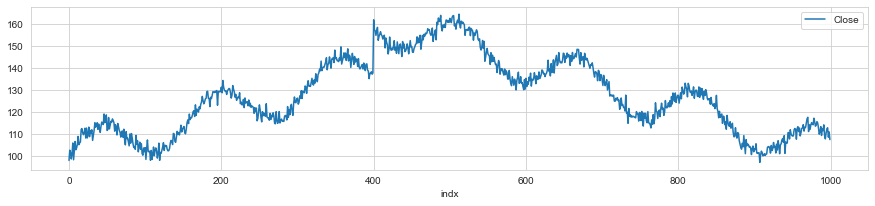

In [51]:
def sinSimulation():
    np.random.seed(123)
    size = 1000
    num= (np.sin(np.linspace(0,40,size))*10)+100
    noise = np.random.normal(0,2,size)
    df= pd.DataFrame({'Close':num+noise})
    df['indx']= df.index
    # df['Close'] = df['Close']+df['indx']*0.1

    def inner(row):
        # print('hello')
        if row['indx']<400:
            return row['Close']+row['indx']*0.1
        else:
            return row['Close']+(102-row['indx']*0.1)

    df['Close']= df.apply(inner, axis=1)
    df.set_index('indx',inplace=True)
    return df

# data, meta_data = ts.get_intraday(symbol='AACG', interval='1min',)
# data, meta_data = ts.get_daily(symbol='BA', outputsize='full')
#df = getAlphaOHLC(data)
df = sinSimulation()
# df['indx'] = np.arange(len(df))
# df.index =df['indx']
df.plot(y='Close', figsize=(15, 3))
# df.drop(columns=['indx'], inplace=True)
df.tail()
print(f'{df.shape}')


<AxesSubplot:xlabel='indx'>

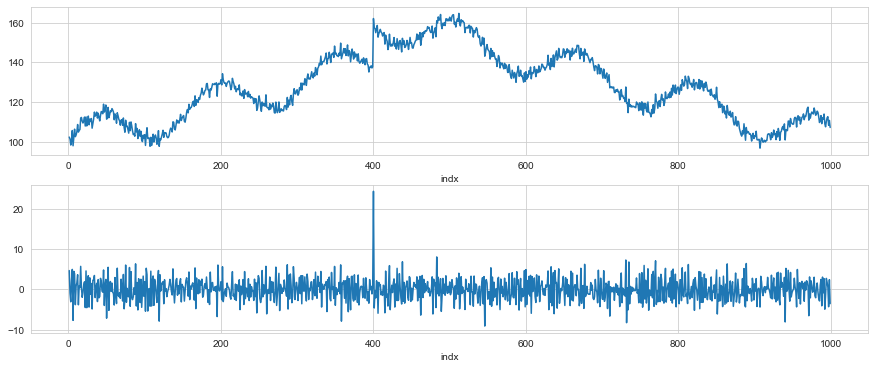

In [52]:
df['ret'] = df['Close'] - df['Close'].shift(1)
ret = df['ret'][1:]
figure, axis = plt.subplots(2,)
ret.plot(figsize=(15, 6))
plt.subplot(2,1,1)
cum = df.Close[0]+np.cumsum(ret)
cum.plot(figsize=(15, 6))

end value 107.32827070926882


,Close,ret,log_ret,log_ret_sum,log_ret_sum_exp
indx,,,,,
0,97.828739,NaN,NaN,NaN,NaN
1,102.494984,4.666246,0.046595,0.046595,1.047698
2,101.565902,-0.929082,-0.009106,0.037489,1.038201
3,98.485725,-3.080177,-0.030796,0.006693,1.006716
4,100.837563,2.351837,0.023599,0.030293,1.030756


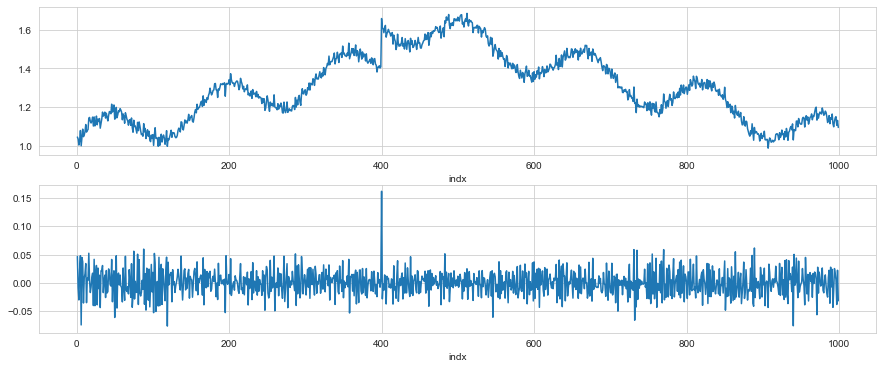

In [53]:
df['log_ret'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
log_ret = df['log_ret'][1:]
df['log_ret_sum'] = np.cumsum(df['log_ret'])
df['log_ret_sum_exp']= np.exp(df['log_ret_sum'])

figure, axis = plt.subplots(2, )
df['log_ret'].plot(figsize=(15, 6))
plt.subplot(2,1,1)
df['log_ret_sum_exp'].plot(figsize=(15, 6))
print(f'end value', df['log_ret_sum_exp'][len(df)-1] * df['Close'][0])
df.head()

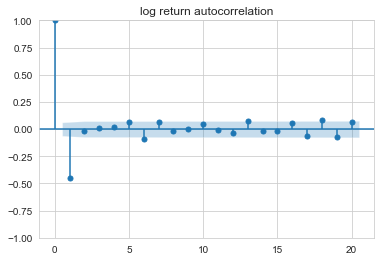

In [54]:
lag = 20
_ = plot_acf(ret, lags=lag, title='log return autocorrelation')

/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


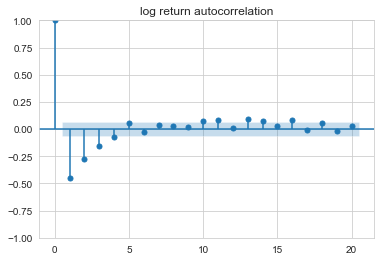

In [55]:
_ = plot_pacf(ret, lags=lag, title='log return autocorrelation')

split start 299 end 700
split 0.3 299
total data length: 999
train data length: 700
test data length: 299


indx
1      4.666246
2     -0.929082
3     -3.080177
4      2.351837
5      4.953966
         ...   
696   -0.468181
697   -4.262678
698    2.781943
699   -0.188033
700   -2.315026
Name: ret, Length: 700, dtype: float64

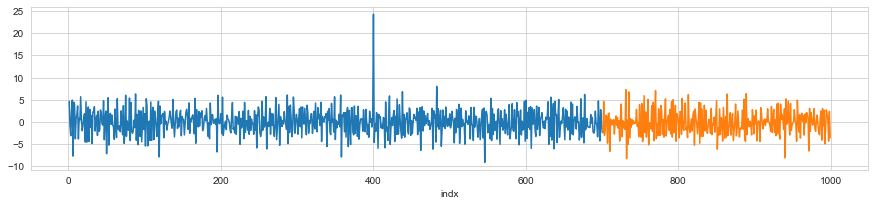

In [56]:
split_percent = 0.3
split = int(len(ret) * split_percent)
split_start = split
split_end = len(ret) - split
print(f'split start {split_start} end {split_end}')
print(f'split {split_percent} {split}')
train_data = ret[:len(ret) -split]
test_data = ret[-1*split:]
train_df = df[:len(df) -split]
test_df = df[-1*split:]
print(f'total data length: {len(ret)}')
print(f'train data length: {len(train_data)}')
print(f'test data length: {len(test_data)}')

train_data.plot(figsize=(15, 3))
test_data.plot(figsize=(15, 3))
train_data

In [57]:
AR_lag_p = 20
MA_lag_q = 2
order = (AR_lag_p, 0, MA_lag_q)
arma_model = ARIMA(train_data, order=order)
arma_result = arma_model.fit()

/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood opti

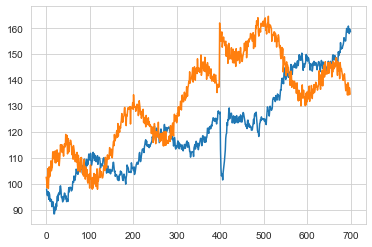

In [58]:
arma_pred = pd.Series(arma_result.fittedvalues)
cum_pred = df.Close[0]+np.cumsum(arma_pred)
cum_ret = df.Close[0]+np.cumsum(train_data.values)
plt.plot(cum_pred, label='predicted')
plt.plot(cum_ret, label='actual')
# plt.plot(lret.values)


/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


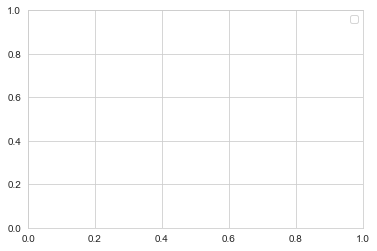

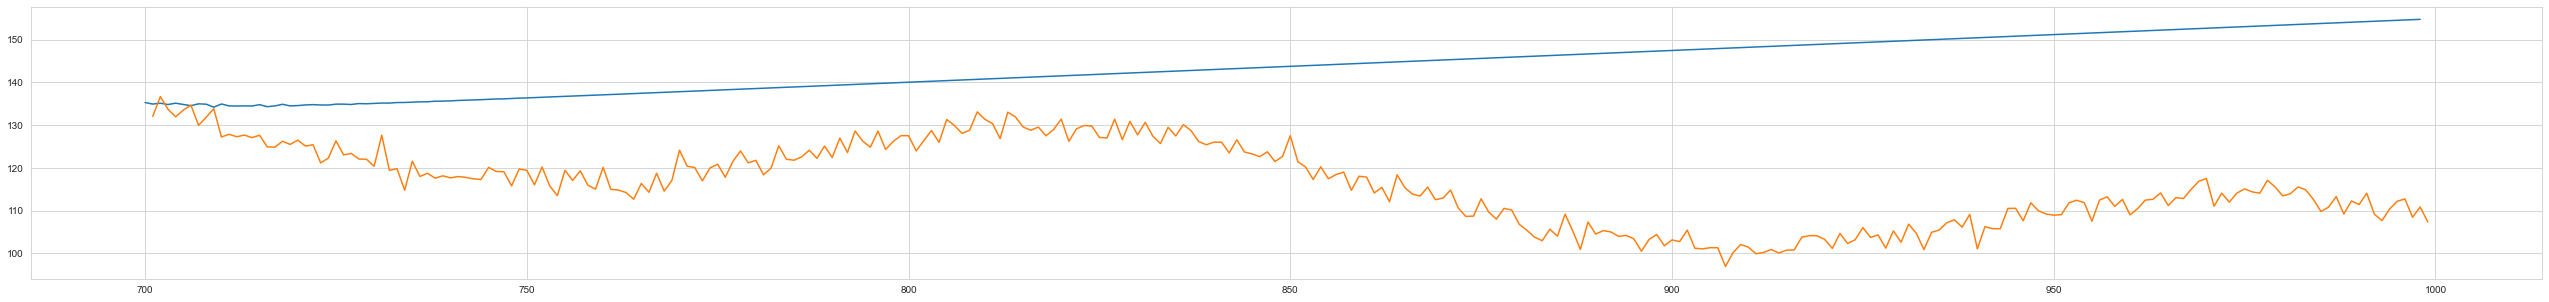

In [59]:

test = arma_result.predict(split_end, len(ret)-1)
cum_test = df.Close[split_end]+np.cumsum(test)
plt.legend()
plt.figure(figsize=(45, 5))
plt.plot(cum_test, label='predicted',)
a= np.cumsum(test_data)+ df.Close[split_end]
plt.plot(a, label='actual')

In [60]:
AR_lag_p = 30
MA_lag_q = 4
order = (AR_lag_p, 1, MA_lag_q)
arma_model = ARIMA(train_df['Close'], order=order)
arma_result = arma_model.fit()

/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


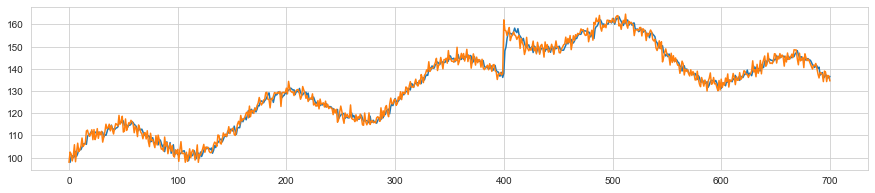

In [61]:
plt.figure(figsize=(15, 3))
plt.plot(arma_result.fittedvalues[1:])
plt.plot(train_df['Close'])

700    136.547604
701    135.059917
702    134.210081
703    135.224961
704    134.122665
705    134.181972
706    134.601835
707    133.352485
708    133.731839
709    134.093190
710    132.794176
711    133.337003
712    133.309861
713    132.914107
714    132.439448
715    132.811517
716    132.956411
717    131.855351
718    132.508418
719    133.035877
Name: predicted_mean, dtype: float64

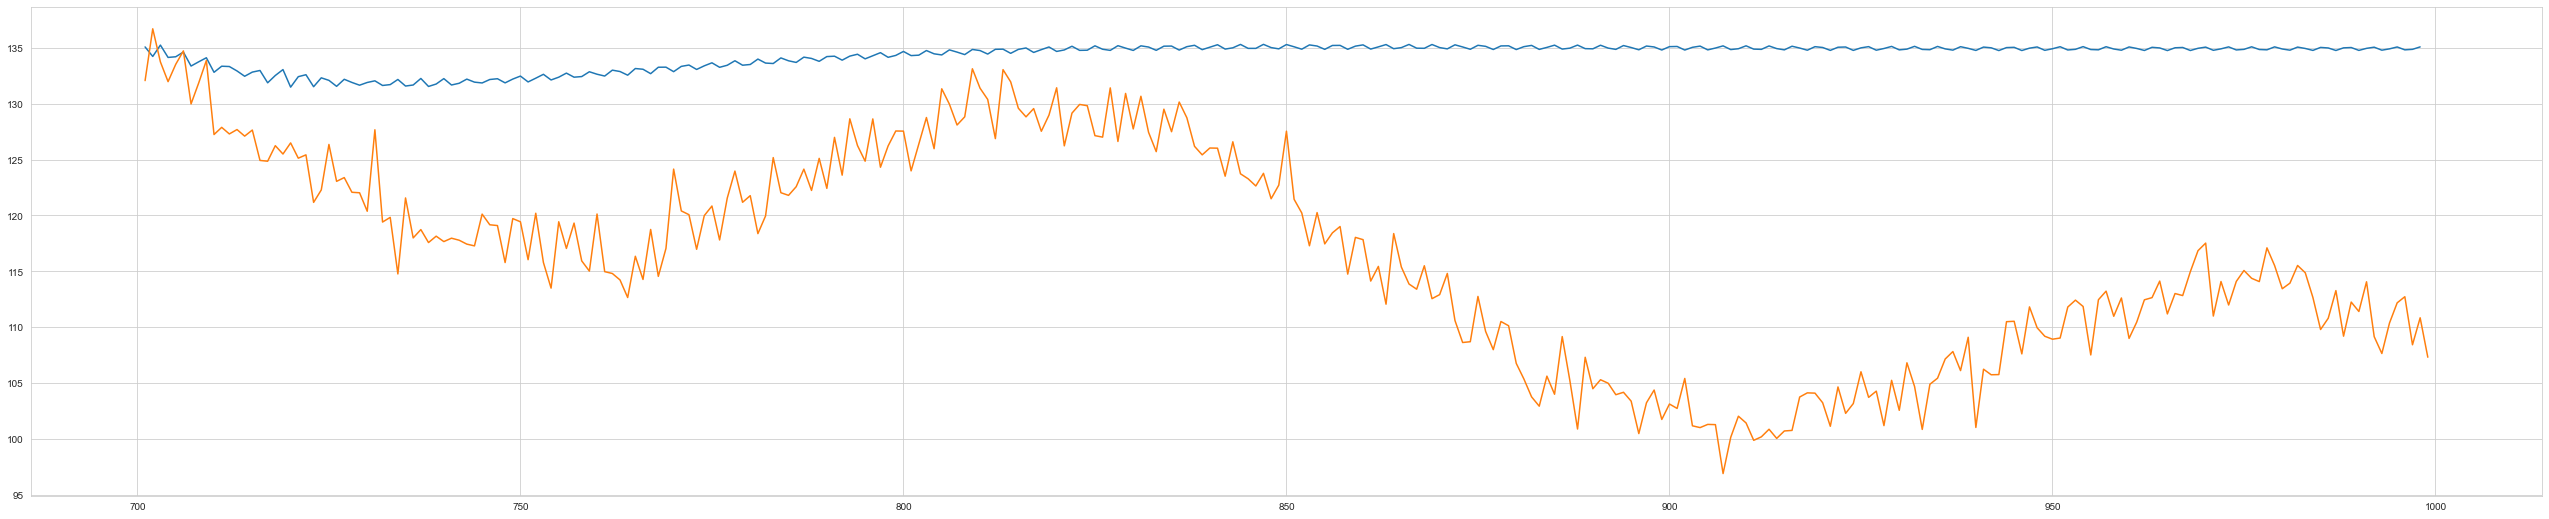

In [62]:
test = arma_result.predict(split_end, len(ret)-1)
plt.figure(figsize=(45, 9))
plt.plot(test[1:])
plt.plot(test_df['Close'])
test.head(20)

In [63]:
my_order = (4,1,4)
my_seasonal_order = (4, 0, 4, 12)
# define model
model = SARIMAX(train_df['Close'], order=my_order, seasonal_order=my_seasonal_order)
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34112D+00    |proj g|=  4.14309D-02

At iterate    5    f=  2.33939D+00    |proj g|=  2.35048D-03

At iterate   10    f=  2.33933D+00    |proj g|=  3.74246D-03

At iterate   15    f=  2.33926D+00    |proj g|=  1.15079D-03

At iterate   20    f=  2.33918D+00    |proj g|=  5.94616D-03

At iterate   25    f=  2.33889D+00    |proj g|=  4.97715D-03

At iterate   30    f=  2.33881D+00    |proj g|=  3.66885D-03

At iterate   35    f=  2.33829D+00    |proj g|=  2.25662D-02

At iterate   40    f=  2.33821D+00    |proj g|=  1.49450D-03

At iterate   45    f=  2.33811D+00    |proj g|=  3.37666D-03


/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.33793D+00    |proj g|=  2.41365D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56      1     0     0   2.414D-03   2.338D+00
  F =   2.3379346490213027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model Fitting Time: 27.700496912002563


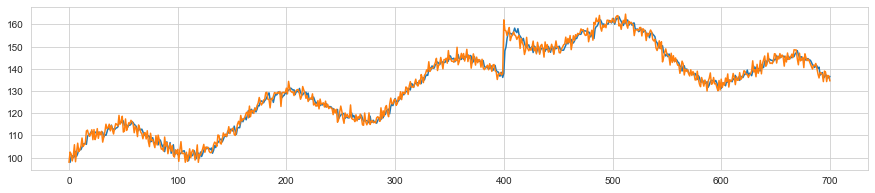

In [64]:
plt.figure(figsize=(15, 3))
plt.plot(arma_result.fittedvalues[1:])
plt.plot(train_df['Close'])

700    136.547604
701    135.059917
702    134.210081
703    135.224961
704    134.122665
705    134.181972
706    134.601835
707    133.352485
708    133.731839
709    134.093190
710    132.794176
711    133.337003
712    133.309861
713    132.914107
714    132.439448
715    132.811517
716    132.956411
717    131.855351
718    132.508418
719    133.035877
Name: predicted_mean, dtype: float64

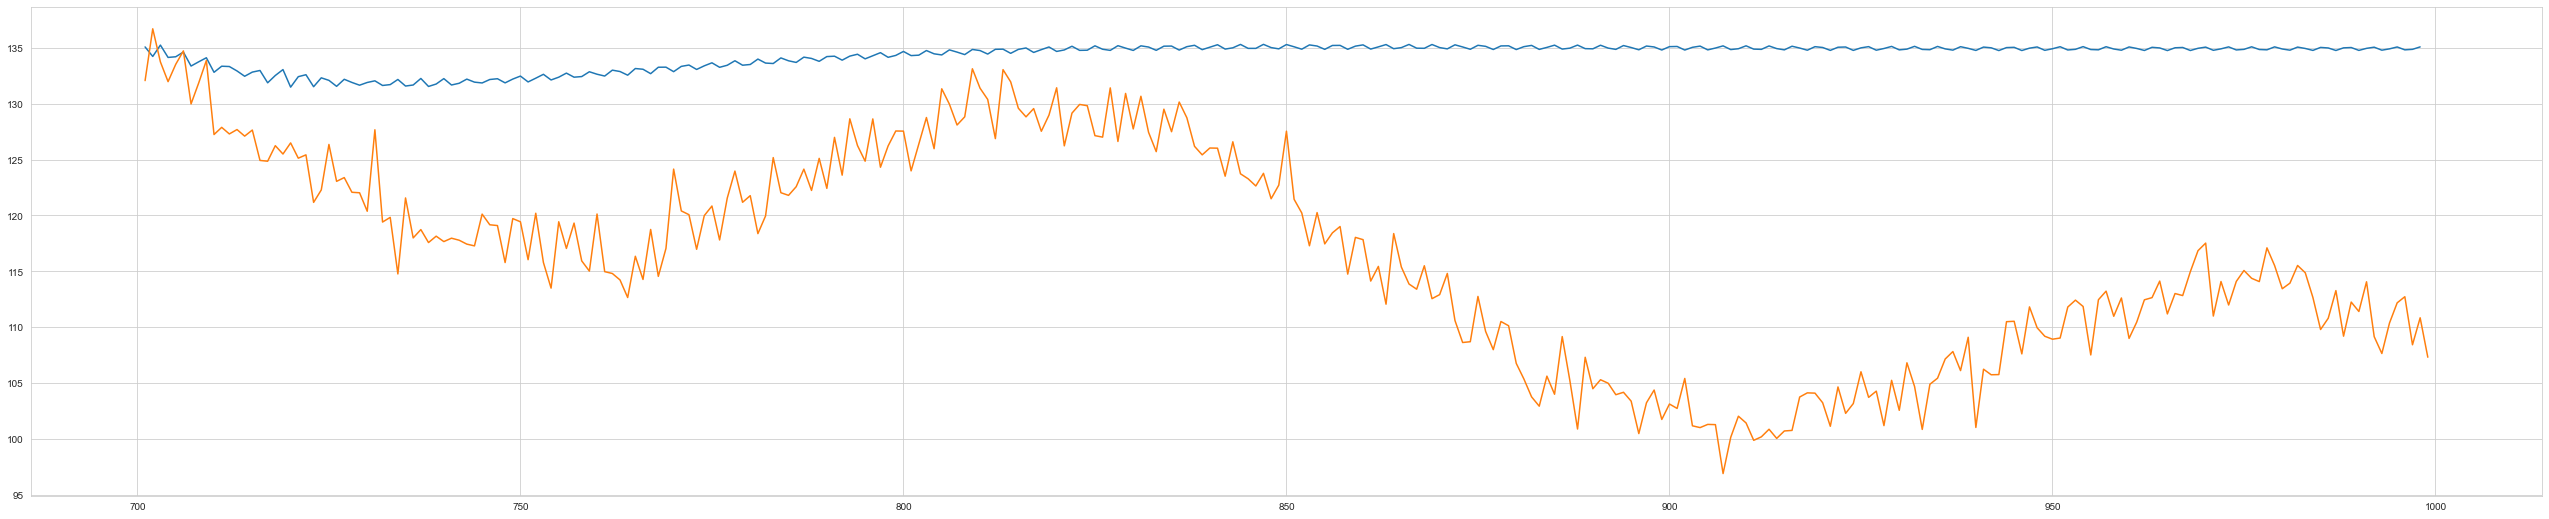

In [65]:
test = arma_result.predict(split_end, len(ret)-1)
plt.figure(figsize=(45, 9))
plt.plot(test[1:])
plt.plot(test_df['Close'])
test.head(20)